# 0. 카카오톡 단체톡방 데이터 분석

- 정말 개인적인 호기심에 의해 시작하게 된 분석이다.
- 단체톡방에서 누가 제일 많이 얘기를 하는지, 또 언제 얘기하는지를 알아볼 것이다!
- 단 단체톡의 대화 내용이나 이름은 공개하지 않는다. (분석 과정은 tail(5)를 통해 일부만 보여줄 것이다.)
- 2018년 12월 이후로 집계된 데이터이다.

# 1. 패키지 임포트 및 데이터 로드

In [94]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib.font_manager as fm
import datetime
import warnings
warnings.filterwarnings(action='ignore')

mpl.rcParams['axes.unicode_minus'] = False

font_location = 'C:/Windows/Fonts/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc('font', family=font_name)

%matplotlib inline

In [95]:
kakao=pd.read_table('KakaoTalkChats.txt')

In [96]:
kakao.tail(5)

,kakao 카카오톡 대화
96595,"2020년 3월 17일 오후 1:18, K : 내보내기"
96596,"2020년 3월 17일 오후 1:18, K : ㄱㄴ?"
96597,"2020년 3월 17일 오후 1:18, 회원님 : 내보내는 중"
96598,"2020년 3월 17일 오후 1:19, K : ㄱㄷ"
96599,"2020년 3월 17일 오후 1:19, K : ㄱㅅ"


- 카카오톡의 '대화 내용 내보내기' 기능을 사용하면 위와 같이 TXT 파일로 받을 수 있다.
- 이를 적절한 전처리 과정을 통해 깔끔한 형태로 만들 것이다.

# 2. 데이터 전처리

## DATETIME, CONTENT 분할
- 우선 CONTENT(내용), DATETIME(시간)으로 분할한다.

In [97]:
kakao.drop(kakao.index[[0,1,2]],inplace=True)
kakao=kakao.reset_index(drop=True)

In [98]:
kakao.tail(5)

,kakao 카카오톡 대화
96592,"2020년 3월 17일 오후 1:18, K : 내보내기"
96593,"2020년 3월 17일 오후 1:18, K : ㄱㄴ?"
96594,"2020년 3월 17일 오후 1:18, 회원님 : 내보내는 중"
96595,"2020년 3월 17일 오후 1:19, K : ㄱㄷ"
96596,"2020년 3월 17일 오후 1:19, K : ㄱㅅ"


In [99]:
kakao.columns=['CONTENT']

In [100]:
kakao['DATETIME'], kakao['CONTENT'] = kakao['CONTENT'].str.split(', ',1).str

In [101]:
kakao.tail(5)

,CONTENT,DATETIME
96592,K : 내보내기,2020년 3월 17일 오후 1:18
96593,K : ㄱㄴ?,2020년 3월 17일 오후 1:18
96594,회원님 : 내보내는 중,2020년 3월 17일 오후 1:18
96595,K : ㄱㄷ,2020년 3월 17일 오후 1:19
96596,K : ㄱㅅ,2020년 3월 17일 오후 1:19


## CONTENT 처리
- CONTENT는 다소 처리가 까다로운 부분이다.
- 먼저 CONTENT 부분에서 첫번째 : 를 기점으로 NAME(이름)과 CONTENT(내용)으로 다시 나눠준다.
- NAME 중 내보내기를 한 사람은 항상 '회원님' 이라는 NAME을 가지므로 이를 처리한다.
- CONTENT 내용 중 'A님이 B님을 초대했습니다.' 나 'C님이 퇴장하였습니다' 같은 경우에는 NAME이 결측치이므로 이를 전부 삭제하도록 한다.
- 마지막으로 미리 정해둔 NAME 리스트에 포함되어 있지 않을 경우 이또한 결측치 처리후, 삭제한다.

In [102]:
kakao['NAME'], kakao['CONTENT'] = kakao['CONTENT'].str.split(' : ',1).str

In [103]:
for i in range(len(kakao)):
    if kakao['NAME'][i] == '회원님':
        kakao['NAME'][i] = 'Y'
    if kakao['NAME'][i] not in ['K','T','Y','O','W', 'S']:
        kakao['NAME'][i] = 'NaN'

In [104]:
kakao=kakao.dropna(axis=0)

In [128]:
name_list=list(kakao.NAME.unique())
name_list

['T', 'Y', 'K', 'O', 'W', 'S']

In [106]:
kakao.tail(5)

,CONTENT,DATETIME,NAME
96592,내보내기,2020년 3월 17일 오후 1:18,K
96593,ㄱㄴ?,2020년 3월 17일 오후 1:18,K
96594,내보내는 중,2020년 3월 17일 오후 1:18,Y
96595,ㄱㄷ,2020년 3월 17일 오후 1:19,K
96596,ㄱㅅ,2020년 3월 17일 오후 1:19,K


## DATETIME 처리
- 카카오톡의 시간은 프로그래밍이나 컴퓨터 시계라기 보단, 사용자가 직관적으로 이해하기 쉬운 구조로 되어있다.
- 새벽 0:59 같은 경우, 오전 12:59로로 되어 있으며
- 오후 12시 다음은 오후 1시로 되돌아 가는 구조이다.
- 이는 추후 분석하는데 다소 어려움을 겪을 수 있으므로 24시간제로 바꾸도록 한다.

In [107]:
kakao['YEAR'], kakao['MONTH'], kakao['DAY'], kakao['AM/PM'], kakao['TIME'] = kakao['DATETIME'].str.split(' ', 4).str
del kakao['DATETIME']

In [108]:
kakao['YEAR']=kakao['YEAR'].str.slice(0,-1)
kakao['MONTH']=kakao['MONTH'].str.slice(0,-1)
kakao['DAY']=kakao['DAY'].str.slice(0,-1)
kakao['HOUR'], kakao['MINUTE'] = kakao['TIME'].str.split(':', 1).str

In [109]:
kakao=kakao.reset_index(drop=True)

In [110]:
kakao.tail(5)

,CONTENT,NAME,YEAR,MONTH,DAY,AM/PM,TIME,HOUR,MINUTE
95124,내보내기,K,2020,3,17,오후,1:18,1,18
95125,ㄱㄴ?,K,2020,3,17,오후,1:18,1,18
95126,내보내는 중,Y,2020,3,17,오후,1:18,1,18
95127,ㄱㄷ,K,2020,3,17,오후,1:19,1,19
95128,ㄱㅅ,K,2020,3,17,오후,1:19,1,19


## 24시간제 처리
- 시간 중 오전이자 12시라고 하면, 새벽 0시이므로 시를 0으로 설정한다.
- 또한 오후 12시를 제외한 오후 1시 ~ 11시는 곧 13~23시를 의미하므로 각 값에 12를 더해준다.

In [111]:
kakao['HOUR'] = pd.to_numeric(kakao['HOUR'])

In [112]:
for i in range(len(kakao)):
    if kakao['AM/PM'][i] == '오전' and int(kakao['HOUR'][i]) == 12:
        kakao['HOUR'][i] = 0
    if kakao['AM/PM'][i] == '오후' and int(kakao['HOUR'][i]) < 12 :
        kakao['HOUR'][i] += 12
        
        

In [113]:
kakao=kakao[['YEAR','MONTH','DAY','HOUR','MINUTE','NAME','CONTENT']]

In [114]:
kakao.tail(5)

,YEAR,MONTH,DAY,HOUR,MINUTE,NAME,CONTENT
95124,2020,3,17,13,18,K,내보내기
95125,2020,3,17,13,18,K,ㄱㄴ?
95126,2020,3,17,13,18,Y,내보내는 중
95127,2020,3,17,13,19,K,ㄱㄷ
95128,2020,3,17,13,19,K,ㄱㅅ


## 요일 처리
- datetime의 weekday 함수를 통해 톡을 보낸 요일의 값을 넣어준다

In [115]:
t=['MON','TUE','WEN','THU','FRI','SAT','SUN']
kakao['WEEKDAY']=''
for i in range(len(kakao)):
    kakao['WEEKDAY'][i] = t[datetime.datetime(int(kakao.iloc[i,0]),int(kakao.iloc[i,1]), int(kakao.iloc[i,2]),int(kakao.iloc[i,3]),int(kakao.iloc[i,4])).weekday()]

In [116]:
kakao.tail(5)

,YEAR,MONTH,DAY,HOUR,MINUTE,NAME,CONTENT,WEEKDAY
95124,2020,3,17,13,18,K,내보내기,TUE
95125,2020,3,17,13,18,K,ㄱㄴ?,TUE
95126,2020,3,17,13,18,Y,내보내는 중,TUE
95127,2020,3,17,13,19,K,ㄱㄷ,TUE
95128,2020,3,17,13,19,K,ㄱㅅ,TUE


# 3. 점유율 분석

## 3.1 전체 점유율
- 이제 모든 전처리 과정이 끝났다. 간단한 분석을 통해 누가 제일 많이 말했는지, 또 이를 시각화하고자 한다.

In [117]:
df=kakao.groupby('NAME').count().sort_values(by=['CONTENT'], ascending=False)

In [118]:
df['PERCENT'] = df['CONTENT']/sum(df['CONTENT'])

In [124]:
df[['CONTENT', 'PERCENT']]

,CONTENT,PERCENT
NAME,,
Y,32101,0.337447
K,28290,0.297386
T,16129,0.169549
O,10777,0.113288
S,7022,0.073816
W,810,0.008515


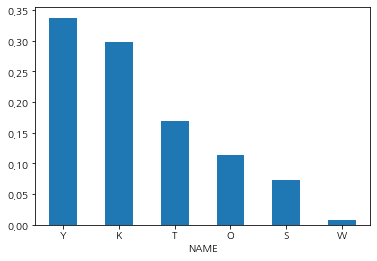

In [125]:
df['PERCENT'].plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

- Y가 3만여건으로 가장 많은 대화지분을 가졌다.
- W는 말을 하는지 마는지 약 1년 반동안 500마디 밖에 안했다... 하루에 한마디씩 하고 사나보다.

## 3.2 시간대별 점유율
- seaborn 패키지의 kdeplot을 통해 어느 시간대에 개인이 말을 하는지 알아보고자 한다.
- 만약 (시간대 - 톡비율) 그래프를 그린다면 막대그래프나 선그래프로 다소 보기 불편할 수도 있다.
- 따라서 Kernal 방법을 통해 유연한 곡선을 그려보고자 한다.

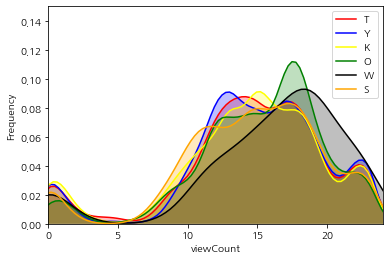

In [131]:
g = sns.kdeplot(kakao['HOUR'][(kakao['NAME'] == 'T') & (kakao["HOUR"].notnull())], color="Red", shade = True)
g = sns.kdeplot(kakao['HOUR'][(kakao['NAME'] == 'Y') & (kakao["HOUR"].notnull())], ax =g, color="Blue", shade= True)
g = sns.kdeplot(kakao['HOUR'][(kakao['NAME'] == 'K') & (kakao["HOUR"].notnull())], ax =g, color="Yellow", shade= True)
g = sns.kdeplot(kakao['HOUR'][(kakao['NAME'] == 'O') & (kakao["HOUR"].notnull())], ax =g, color="Green", shade= True)
g = sns.kdeplot(kakao['HOUR'][(kakao['NAME'] == 'W') & (kakao["HOUR"].notnull())], ax =g, color="Black", shade= True)
g = sns.kdeplot(kakao['HOUR'][(kakao['NAME'] == 'S') & (kakao["HOUR"].notnull())], ax =g, color="Orange", shade= True)


g.set_xlabel("viewCount")
g.set_ylabel("Frequency")
g.axis([0,24,0,0.15])
g = g.legend(name_list)

- 6명 모두 한 그래프에 그리니 개인의 특징을 잘 살리기가 어려웠다.
- 그 중 'O' 는 직장인이고, 'Y' 는 아직 졸업을 한지 얼마 되지 않았다. 따라서 두명만 따로 알아보고자 한다.

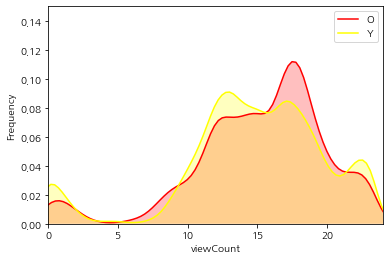

In [133]:
g = sns.kdeplot(kakao['HOUR'][(kakao['NAME'] == 'O') & (kakao["HOUR"].notnull())], color="Red", shade = True)
g = sns.kdeplot(kakao['HOUR'][(kakao['NAME'] == 'Y') & (kakao["HOUR"].notnull())], ax =g, color="Yellow", shade= True)


g.set_xlabel("viewCount")
g.set_ylabel("Frequency")
g.axis([0,24,0,0.15])
g = g.legend(["O",'Y'])

- 'O' 는 9시~15시까지 다소 저조하다가 퇴근시간이 되면 보다 톡이 많아진다.
- 하지만 학생이었던 'Y'는 다소 시간이 들쑥날쑥하기도 하며 특히 22~02시에도 톡이 보다 활발한 것을 볼 수 있었다.

## 3.3 요일별 점유율

### 3.3.1 전체 점유율

In [135]:
output=pd.DataFrame(kakao.groupby('WEEKDAY').count()['CONTENT'])
output=output.reindex(t)
output['PERCENT'] = output['CONTENT']/sum(output['CONTENT'])
output

,CONTENT,PERCENT
WEEKDAY,,
MON,11466,0.120531
TUE,14999,0.157670
WEN,13302,0.139831
THU,16539,0.173859
FRI,18053,0.189774
SAT,13030,0.136972
SUN,7740,0.081363


- 역시 불금아니랄까봐 금요일에 가장 많은 톡을 보내고 있다.
- 눈에 띄는 것은 역시 월요병인가 보다! 월요일에는 평일 중 가장 저조한 톡을 보내고 있다.
- 일요일은 모두 쉬는 날이니 톡도 쉬나보다.

### 3.3.2 개인별 점유율
- 개인별로 어느 요일에 가장 대화가 활발한지 알아보가자 한다.
- 엑셀에서 있는 피벗테이블은 파이썬에 이미 구현되어 있다. 이 기능을 통해 각자의 점유율을 알아보고자 한다.

In [141]:
output=pd.pivot_table(kakao, index = 'NAME',columns='WEEKDAY', values = 'CONTENT', aggfunc = 'count')
output['SUM']=''

In [142]:
for i in range(len(output)):
    output.iloc[i,7] = sum(output.iloc[i,0:7])

In [143]:
for i in range(output.shape[0]):
    for j in range(output.shape[1]-1):
        output.iloc[i,j] = format(output.iloc[i,j] / output.iloc[i,7], '10.1%')

In [144]:
output=output[t]
output

WEEKDAY,MON,TUE,WEN,THU,FRI,SAT,SUN
NAME,,,,,,,
K,12.4%,16.5%,14.5%,18.3%,18.6%,12.3%,7.5%
O,8.0%,12.1%,13.3%,16.6%,22.4%,17.7%,9.8%
S,13.2%,16.2%,15.1%,18.6%,19.5%,10.4%,7.0%
T,11.5%,17.1%,14.0%,16.3%,19.1%,14.4%,7.7%
W,10.7%,10.0%,11.6%,11.1%,18.8%,17.8%,20.0%
Y,13.2%,15.7%,13.6%,17.3%,18.0%,13.8%,8.3%


- 가장 눈에 띄는 것은 역시 직장인 'O'다.
- 월요일에서 금요일로 갈수록 주말을 기다리는 마음에 점점 말이 많아진다!
- 평균적으로 금요일로 갈수록 비율이 늘어나는 것을 볼 수 있다.

# 4. 컨텐츠 분석
- 카카오톡에는 '사진', '이모티콘' 같이 텍스트가 아닌 다른 컨텐츠를 보내는 기능도 있다.
- 누가 가장 많이 사용했는지 알아보고자 한다.
- 추후 다른 분석에서는 다른 키워드를 통해 더 흥미로운 결과를 얻을 수 있을 것이다.

## 4.1 사진 매니아

In [155]:
df=kakao[kakao['CONTENT']=='사진']

In [156]:
pd.DataFrame(df.groupby('NAME').count()['CONTENT']).sort_values(by=['CONTENT'], ascending=False)

,CONTENT
NAME,
Y,626
K,579
T,342
O,158
S,121
W,11


- 'Y'는 가장 많은 사진을 보내고 있었다!

## 4.2 유튜브 업로더

In [157]:
df=kakao[kakao.CONTENT.str.contains('www.youtube.com', na=False)]

In [159]:
df.groupby('NAME').count().sort_values(by=['CONTENT'], ascending=False)

,YEAR,MONTH,DAY,HOUR,MINUTE,CONTENT,WEEKDAY
NAME,,,,,,,
Y,194,194,194,194,194,194,194
K,48,48,48,48,48,48,48
O,29,29,29,29,29,29,29
T,24,24,24,24,24,24,24


- 역시 'Y'는 유튜브 영상을 가장 많이 보내고 있었다...
- 값이 없는 사람은 단 한번도 유튜브 업로드를 하지 않았거나 '샵검색' 이라는 기능을 통해 업로드하고 있었다.

# 5. 마치며
- 간단한 비율 분석이나 콘텐츠 분석을 통해 재미있느 결과를 도출하였다!
- 다음 분석에서는 자연어처리를 통해 어떤 주제로 이야기를 많이 하는지, 또 각자 가장 많이 얘기하는 주제는 무엇인지 알아보고자 한다.